# Boosting and the AdaBoost Method

Using **ensemble methods** can greatly improve the results achieved with weak machine learning algorithms, also called **weak learners**. Ensemble methods achieve better performance by aggregating the results of many statistically independent models. This process averages out the errors and produces a better, final, prediction. 

In this lab you will work with widely used ensemble method known as **boosting**. Boosting is a meta-algorithm since the method can be applied to many types of machine learning algorithms. In summary, boosting iteratively improves the learning of the N models by giving greater weight to training cases with larger errors. The basic boosting procedure is simple and follows these steps:
1. N learners (machine learning models) are defined.
2. Each of i training data cases is given an initial equal weight of 1/i.
3. The N learners are trained on the weighted training data cases.
4. The prediction is computed based on a aggregation of the learners; averaging over the hypothesis of the N learners. 
5. Weights for the training data cases are updated based on the aggregated errors made by the learners. Cases with larger errors are given larger weights. 
6. Steps 3, 4, and 5 are repeated until a convergence criteria is met.

**Classification and regression tree models** are the weak learners most commonly used with boosting. In this lab you will work with one of the most widely used and successful boosted methods, known as **AdaBoost** or **adaptive boosting**. AdaBoost uses some large number, N, tree models. The rate at which weights are updated is **adaptive** with the errors. 

It is important to keep in mind that boosted machine learning is not robust to significant noise or outliers in the training data. The reweighting process gives greater weight to the large errors, and therefore can give undue weight to outliers and errors. In cases where data is noisy, the random forest algorithm may prove to be more robust. 

## Example: Iris dataset

As a first example you will use AdaBoost to classify the species of iris flowers. 

As a first step, execute the code in the cell below to load the required packages to run the rest of this notebook. 

In [108]:
## Import packages
library(ggplot2)
library(gridExtra)
library(repr)
library(dplyr)
library(caret)
library(gbm)
library(e1071)
library(ROCR)

options(repr.plot.width=4, repr.plot.height=4) # Set the initial plot area dimensions

To get a feel for these data, you will now load and plot them. The code in the cell below does the following:

1. Loads the iris data as a Pandas data frame. 
2. Adds column names to the data frame.
3. Displays all 4 possible scatter plot views of the data. 

Execute this code and examine the results. 

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa
4.9,3.1,1.5,0.1,setosa


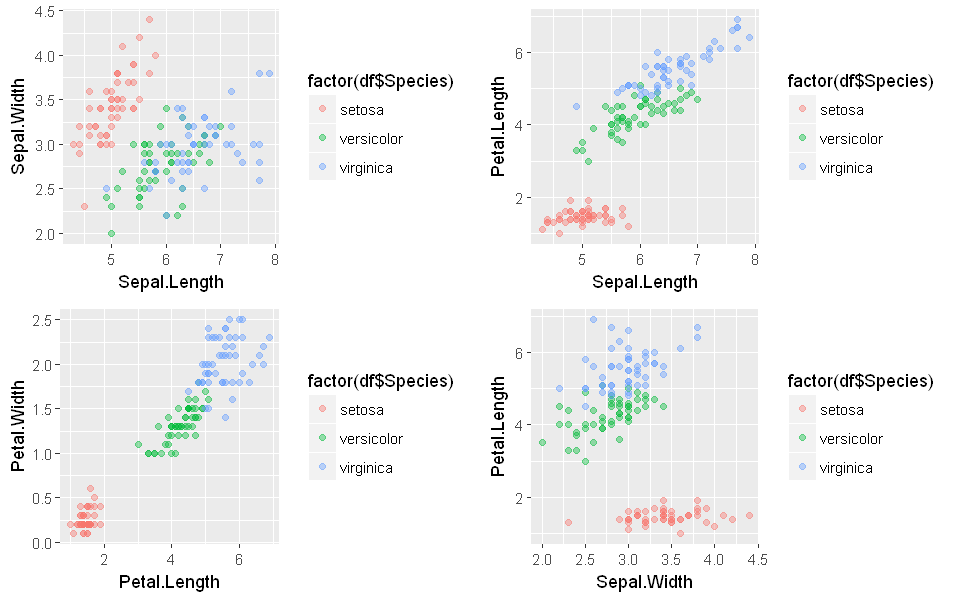

In [109]:
single_plot = function(df, colx, coly){
    ggplot(df, aes_string(colx,coly)) +
          geom_point(aes(color = factor(df$Species)), alpha = 0.4)
}

plot_iris = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot(df, 'Sepal.Length', 'Petal.Length'),
        single_plot(df, 'Petal.Length', 'Petal.Width'),
        single_plot(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
}

head(iris, 10)   
plot_iris(iris) 

You can see that Setosa (in blue) is well separated from the other two categories. The Versicolor (in orange) and the Virginica (in green) show considerable overlap. The question is how well our classifier will separate these categories. 

Next, execute the code in the cell below to split the dataset into test and training set. Notice that unusually, 67% of the cases are being used as the test dataset. 

In [110]:
set.seed(1955)
## Randomly sample cases to create independent training and test data
partition = createDataPartition(iris[,'Species'], times = 1, p = 0.33, list = FALSE)
training = iris[partition,] # Create the training sample
dim(training)
test = iris[-partition,] # Create the test sample
dim(test)

[1] 51  5

[1] 99  5

As is always the case with machine learning, numeric features  must be scaled. Execute the code in the cell below to scale the training and test datasets:

In [111]:
num_cols = c('Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width')
preProcValues <- preProcess(training[,num_cols], method = c("center", "scale"))

training[,num_cols] = predict(preProcValues, training[,num_cols])
test[,num_cols] = predict(preProcValues, test[,num_cols])
head(training[,num_cols])

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
3,-1.2646501,0.4563512,-1.348274,-1.287390
5,-0.9016267,1.4161001,-1.293220,-1.287390
6,-0.4175955,2.1359118,-1.128059,-1.027876
9,-1.6276734,-0.2634605,-1.293220,-1.287390
10,-1.0226345,0.2164140,-1.238167,-1.417146
11,-0.4175955,1.6560373,-1.238167,-1.287390


Now you will define and fit an AdaBoosted tree model. The code in the cell below defines the model with 100 estimators (trees) using the `AdaBoostClassifer` function from the Scikit Learn ensemble  package, and then fits the model. Execute this code.

In [112]:
set.seed(3355)
gbm_mod = gbm(Species ~ ., data = training, distribution = "multinomial", n.trees = 5)

Notice that the many hyperparameters of the AdaBoosted tree model object are displayed. 

Next, the code in the cell below uses the `predict` method is used to compute the scores from the scaled features. 

Execute this code. 

In [113]:
test$probs = predict(gbm_mod, newdata = test, n.trees = 5)
test[1:10,]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,probs
1,-0.78061890,1.17616289,-1.293220,-1.287390,setosa,0.011800578
2,-1.02263448,-0.02352326,-1.293220,-1.287390,setosa,0.011800578
4,-1.38565786,0.21641397,-1.238167,-1.287390,setosa,0.011800578
7,-1.38565786,0.93622566,-1.293220,-1.157633,setosa,0.011800578
8,-0.90162669,0.93622566,-1.238167,-1.287390,setosa,0.011800578
12,-1.14364227,0.93622566,-1.183113,-1.287390,setosa,0.011800578
14,-1.74868124,-0.02352326,-1.458381,-1.417146,setosa,0.011800578
15,0.06643565,2.37584904,-1.403328,-1.287390,setosa,-0.003465665
16,-0.05457214,3.33559795,-1.238167,-1.027876,setosa,-0.003465665
19,-0.05457214,1.89597458,-1.128059,-1.157633,setosa,-0.003465665


In [114]:
test$scores = apply(test$probs, 1, which.max) # Find the class with the maximum probability
test$scores = ifelse(test$scores == 1, 'sentosa', ifelse(test$scores == 2, 'versicolor', 'virginica'))
test[1:10,]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,probs,scores
1,-0.78061890,1.17616289,-1.293220,-1.287390,setosa,0.011800578,sentosa
2,-1.02263448,-0.02352326,-1.293220,-1.287390,setosa,0.011800578,sentosa
4,-1.38565786,0.21641397,-1.238167,-1.287390,setosa,0.011800578,sentosa
7,-1.38565786,0.93622566,-1.293220,-1.157633,setosa,0.011800578,sentosa
8,-0.90162669,0.93622566,-1.238167,-1.287390,setosa,0.011800578,sentosa
12,-1.14364227,0.93622566,-1.183113,-1.287390,setosa,0.011800578,sentosa
14,-1.74868124,-0.02352326,-1.458381,-1.417146,setosa,0.011800578,sentosa
15,0.06643565,2.37584904,-1.403328,-1.287390,setosa,-0.003465665,versicolor
16,-0.05457214,3.33559795,-1.238167,-1.027876,setosa,-0.003465665,versicolor
19,-0.05457214,1.89597458,-1.128059,-1.157633,setosa,-0.003465665,versicolor


It is time to evaluate the model results. Keep in mind that the problem has been made deliberately difficult, by having more test cases than training cases. 

The iris data has three species categories. Therefore it is necessary to use evaluation code for a three category problem. The function in the cell below extends code from pervious labs to deal with a three category problem. Execute this code and examine the results.

In [115]:
print_metrics = function(df, label){
    ## Compute and print the confusion matrix
    cm = as.matrix(table(Actual = df$Species, Predicted = df$scores))
    print(cm)

    ## Compute and print accuracy 
    accuracy = round(sum(sapply(1:nrow(cm), function(i) cm[i,i]))/sum(cm), 3)
    cat('\n')
    cat(paste('Accuracy = ', as.character(accuracy)), '\n \n')                           

    ## Compute and print precision, recall and F1
    precision = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[i,]))
    recall = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[,i]))    
    F1 = sapply(1:nrow(cm), function(i) 2*(recall[i] * precision[i])/(recall[i] + precision[i]))    
    metrics = sapply(c(precision, recall, F1), round, 3)        
    metrics = t(matrix(metrics, nrow = nrow(cm), ncol = ncol(cm)))       
    dimnames(metrics) = list(c('Precision', 'Recall', 'F1'), unique(test$Species))      
    print(metrics)
}  
print_metrics(test, 'Species')   

            Predicted
Actual       sentosa versicolor virginica
  setosa          30          3         0
  versicolor       4         20         9
  virginica        1          0        32

Accuracy =  0.828 
 
          setosa versicolor virginica
Precision  0.909      0.606     0.970
Recall     0.857      0.870     0.780
F1         0.882      0.714     0.865


Examine these results. Notice the following:
1. The confusion matrix has dimension 3X3. You can see that most cases are correctly classified with only a few errors. 
2. The overall accuracy is 0.95. Since the classes are roughly balanced, this metric indicates relatively good performance of the classifier, particularly since it was only trained on 50 cases. 
3. The precision, recall and  F1 for each of the classes is quite good.

To get a better feel for what the classifier is doing, the code in the cell below displays a set of plots showing correctly (as '+') and incorrectly (as 'o') cases, with the species color-coded. Execute this code and examine the results. 

In [116]:
set.seed(8899)
gbm_mod = gbm(Species ~ ., data = training, distribution = "multinomial", n.trees = 100)
test$probs = predict(gbm_mod, newdata = test, n.trees = 100)
test$scores = apply(test$probs, 1, which.max) # Find the class with the maximum probability
test$scores = ifelse(test$scores == 1, 'sentosa', ifelse(test$scores == 2, 'versicolor', 'virginica'))
print_metrics(test, 'Species')  

            Predicted
Actual       sentosa versicolor virginica
  setosa          33          0         0
  versicolor       2         21        10
  virginica        0          1        32

Accuracy =  0.869 
 
          setosa versicolor virginica
Precision  1.000      0.636     0.970
Recall     0.943      0.955     0.762
F1         0.971      0.764     0.853


In [117]:
capture.output(
    gbm_mod_train = train(Species ~ ., data = training, method = "gbm",
            distribution = "multinomial", trControl=trainControl(number=100),
            tuneGrid=expand.grid(n.trees = 100,
                                 interaction.depth = 1, 
                                 n.minobsinnode = 10, 
                                 shrinkage = 0.001)),
    file = 'Nul'
)

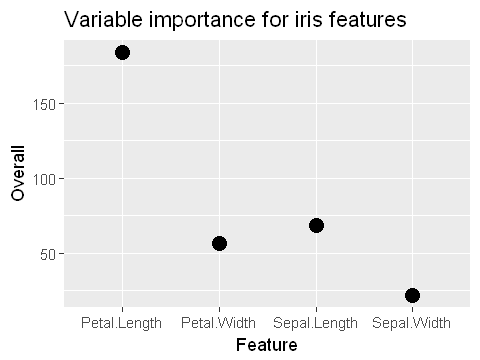

In [118]:
options(repr.plot.width=4, repr.plot.height=3)
imp = varImp(gbm_mod_train, scale = FALSE)$importance
imp[,'Feature'] = row.names(imp)
ggplot(imp, aes(x = Feature, y = Overall)) + geom_point(size = 4) +
       ggtitle('Variable importance for iris features')

In [119]:
relative.influence(gmb_mod, n.trees = 100)

Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
     0.00000     45.59210    468.17488     80.15582

In [120]:
set.seed(8899)
gbm_mod = gbm(Species ~ Petal.Length + Petal.Width + Sepal.Length, 
              data = training, distribution = "multinomial", n.trees = 100)
test$probs = predict(gbm_mod, newdata = test, n.trees = 100)
test$scores = apply(test$probs, 1, which.max) # Find the class with the maximum probability
test$scores = ifelse(test$scores == 1, 'sentosa', ifelse(test$scores == 2, 'versicolor', 'virginica'))
print_metrics(test, 'Species')  

            Predicted
Actual       sentosa versicolor virginica
  setosa          33          0         0
  versicolor       2         24         7
  virginica        0          1        32

Accuracy =  0.899 
 
          setosa versicolor virginica
Precision  1.000      0.727     0.970
Recall     0.943      0.960     0.821
F1         0.971      0.828     0.889


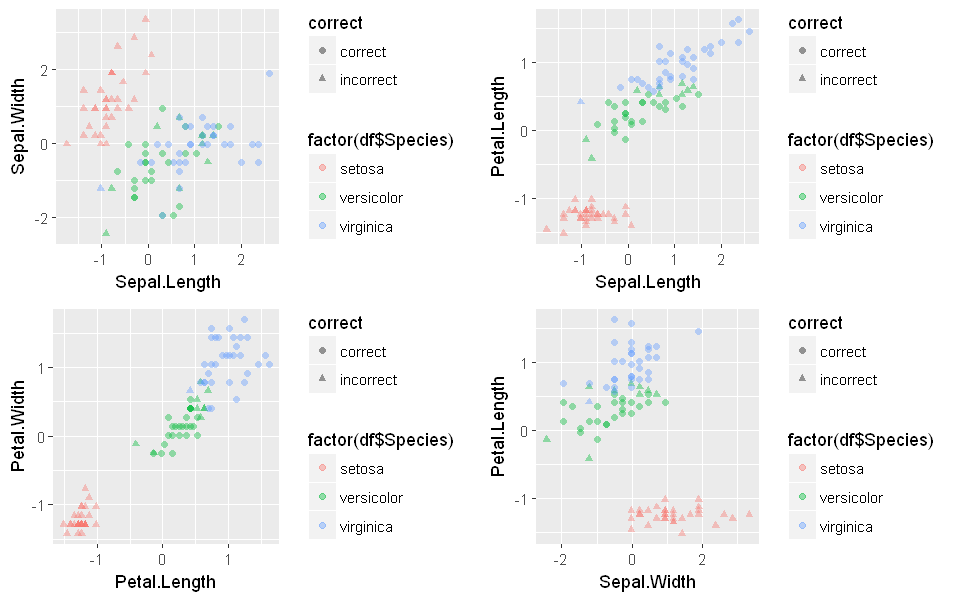

In [121]:
## Create column of correct-incorrect classification
test$correct = ifelse(test$Species == test$scores, 'correct', 'incorrect')

single_plot_classes = function(df, colx, coly){
    ggplot(df, aes_string(colx,coly)) +
          geom_point(aes(color = factor(df$Species), shape = correct), alpha = 0.4)
}

plot_iris_classes = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot_classes(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot_classes(df, 'Sepal.Length', 'Petal.Length'),
        single_plot_classes(df, 'Petal.Length', 'Petal.Width'),
        single_plot_classes(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
}

plot_iris_classes(test)

Examine these plots. You can see how the classifier has divided the feature space between the classes. Notice that most of the errors occur in the overlap region between Virginica and Versicolor. This behavior is to be expected.  

## Another example

Now, you will try a more complex example using the credit scoring data. You will use the prepared data which had the following preprocessing:
1. Remove duplicate cases.
2. Aggregating categories of certain categorical variables. 

Execute the code in the cell below to load the dataset for the example. 

In [122]:
credit = read.csv('German_Credit_Preped.csv', header = TRUE)
## Subset the data frame
credit = credit[,c('checking_account_status', 'loan_duration_mo', 'credit_history', 'loan_amount', 'savings_account_balance',
                   'time_employed_yrs', 'payment_pcnt_income', 'time_in_residence', 'property', 'age_yrs',
                   'other_credit_outstanding', 'number_loans', 'job_category', 'dependents', 'telephone', 'bad_credit' )]
print(dim(credit))
names(credit)

[1] 999  16


[1] "checking_account_status"  "loan_duration_mo"        
 [3] "credit_history"           "loan_amount"             
 [5] "savings_account_balance"  "time_employed_yrs"       
 [7] "payment_pcnt_income"      "time_in_residence"       
 [9] "property"                 "age_yrs"                 
[11] "other_credit_outstanding" "number_loans"            
[13] "job_category"             "dependents"              
[15] "telephone"                "bad_credit"

Cross validation will be used to train the model. Since folds will be selected from the entire dataset the numeric features are scaled in batch. Execute the code in the cell below to accomplish this: 

In [123]:
num_cols = c('loan_duration_mo', 'loan_amount', 'payment_pcnt_income',
             'time_in_residence', 'age_yrs', 'number_loans', 'dependents')

preProcValues <- preProcess(credit[,num_cols], method = c("center", "scale"))
credit[,num_cols] = predict(preProcValues, credit[,num_cols])
head(credit[,num_cols])

loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
2.2464282,0.9483849,-0.86876113,-0.7645835,-1.19202026,-0.7035652,-0.4283287
-0.7397312,-0.4170067,-0.86876113,0.1414888,1.18945982,-0.7035652,2.3323187
1.7487350,1.6323204,-0.86876113,1.0475610,0.83664795,-0.7035652,2.3323187
0.2556552,0.5655086,0.02505181,1.0475610,1.54227168,1.0276211,2.3323187
1.2510417,2.0477820,-0.86876113,1.0475610,-0.04538171,-0.7035652,2.3323187
0.2556552,-0.1552623,0.02505181,1.0475610,1.54227168,-0.7035652,-0.4283287


The code in the cell below estimates the best hyperparameters using 10 fold cross validation. There are a few points to notice here:
1. In this case, a grid of one hyperparameter is searched: 
  - learning rate shrinks the contribution of each classifier by learning_rate. There is a trade-off between learning_rate and n_estimators
2. There is a class imbalance and a difference in the cost to the bank of misclassification of a bad credit risk customer. This will be addressed later. 
3. The model is fit on each set of hyperparameters from the grid. 
4. The best estimated hyperparameters are printed. 

Notice that the model uses regularization rather than feature selection. The hyperparameter search is intended to optimize the level of regularization. 

Execute this code, examine the result, and answer **Question 2** on the course page. 

In [15]:
## Define the dictionary for the grid search and the model object to search on
param_grid = {"learning_rate": [0.1, 1, 10]}
## Define the AdaBoosted tree model
nr.seed(3456)
ab_clf = AdaBoostClassifier(n_estimators=100)  

## Perform the grid search over the parameters
nr.seed(4455)
ab_clf = ms.GridSearchCV(estimator = ab_clf, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = sklm.make_scorer(sklm.roc_auc_score),
                      return_train_score = True)
ab_clf.fit(Features, Labels)
print(ab_clf.best_estimator_.learning_rate)

1


Now, you will run the code in the cell below to perform the outer cross validation of the model. 

In [16]:
nr.seed(498)
cv_estimate = ms.cross_val_score(ab_clf, Features, Labels, 
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('fold ' + str(i+1) + '   %4.3f' % x)

Mean performance metric = 0.643
SDT of the metric       = 0.058
Outcomes by cv fold
fold 1   0.726
fold 2   0.693
fold 3   0.612
fold 4   0.622
fold 5   0.727
fold 6   0.647
fold 7   0.556
fold 8   0.674
fold 9   0.613
fold 10   0.560


Examine these results. Notice that the standard deviation of the mean of the AUC is more than an order of magnitude smaller than the mean. This indicates that this model is likely to generalize well. 

Now, you will build and test a model using the estimated optimal hyperparameters. As a first step, execute the code in the cell below to create training and testing datasets.

In [17]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
x_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

The code in the cell below defines an AdaBoosted tree model object using the estimated optimal model hyperparameters and then fits the model to the training data. Execute this code.

In [18]:
nr.seed(1115)
ab_mod = AdaBoostClassifier(n_estimators=100, learning_rate = 1) 
ab_mod.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=100, random_state=None)

As expected, the hyperparameters of the AdaBoosted tree model object reflect those specified. 

The code in the cell below scores and prints evaluation metrics for the model, using the test data subset. Execute this code and examine the results. 

In [19]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('True positive    %6d' % conf[0,0] + '          %5d' % conf[0,1])
    print('True negative    %6d' % conf[1,0] + '          %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, scores))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('             Positive   Negative')
    print('Num case    %0.2f' % metrics[3][0] + '       %0.2f' % metrics[3][1])
    print('Precision   %0.2f' % metrics[0][0] + '          %0.2f' % metrics[0][1])
    print('Recall      %0.2f' % metrics[1][0] + '          %0.2f' % metrics[1][1])
    print('F1          %0.2f' % metrics[2][0] + '          %0.2f' % metrics[2][1])

scores = ab_mod.predict(x_test)
print_metrics(y_test, scores)     

                 Confusion matrix
                 Score positive    Score negative
True positive       188             29
True negative        46             37

Accuracy        0.75
AUC             0.66
Macro precision 0.68
Macro recall    0.66
 
             Positive   Negative
Num case    217.00       83.00
Precision   0.80          0.56
Recall      0.87          0.45
F1          0.83          0.50


Overall, these performance metrics are poor. The majority of negative cases have been misclassified as positive. Adaboosted methods are sensitive to class imbalance. 

It is likely that the poor performance arises from the class imbalance. Notice that there is no way to reweight classes with boosting methods. Some alternatives are:
1. **Impute** new values using a statistical algorithm. 
2. **Undersample** the majority cases. For this method a number of the cases equal to the minority case are Bernoulli sampled from the majority case. 
3. **Oversample** the minority cases. For this method the number of minority cases are resampled until they equal the number of majority cases.

The code in the cell below undersamples the majority cases; good credit customers. The `choice` function from the numpy.random package is used to randomize the undersampling. The count of unique label values and the shape of the resulting arrays is printed. Execute this code to create a data set with balanced cases. 

In [20]:
temp_Labels_1 = Labels[Labels == 1]  # Save these
temp_Features_1 = Features[Labels == 1,:] # Save these
temp_Labels_0 = Labels[Labels == 0]  # Undersample these
temp_Features_0 = Features[Labels == 0,:] # Undersample these

indx = nr.choice(temp_Features_0.shape[0], temp_Features_1.shape[0], replace=True)

temp_Features = np.concatenate((temp_Features_1, temp_Features_0[indx,:]), axis = 0)
temp_Labels = np.concatenate((temp_Labels_1, temp_Labels_0[indx,]), axis = 0) 

print(np.bincount(temp_Labels))
print(temp_Features.shape)
print(temp_Labels.shape)

[300 300]
(600, 35)
(600,)


There are now 300 of each label case with 600 cases overall. The question is, will using these data produce better results?

You will perform model selection and evaluation using nested cross validation. The code in the cell below finds the optimal learning rate parameter using cross validation. 

Once you have executed the code, answer **Question 3** on the course page.

In [21]:
nr.seed(1234)
inside = ms.KFold(n_splits=10, shuffle = True)
nr.seed(3214)
outside = ms.KFold(n_splits=10, shuffle = True)

## Define the AdaBoosted tree model
nr.seed(3456)
ab_clf = AdaBoostClassifier(n_estimators=100)  

## Perform the grid search over the parameters
nr.seed(4455)
ab_clf = ms.GridSearchCV(estimator = ab_clf, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = sklm.make_scorer(sklm.roc_auc_score),
                      return_train_score = True)
ab_clf.fit(temp_Features, temp_Labels)
print(ab_clf.best_estimator_.learning_rate)

0.1


Notice that the estimated optimal learning rate parameter is smaller than before.

Now, run the code in the cell below to execute the outer loop of the cross validation. 

In [22]:
nr.seed(498)
cv_estimate = ms.cross_val_score(ab_clf, temp_Features, temp_Labels, 
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('fold ' + str(i+1) + '   %4.3f' % x)

Mean performance metric = 0.712
SDT of the metric       = 0.041
Outcomes by cv fold
fold 1   0.684
fold 2   0.700
fold 3   0.632
fold 4   0.714
fold 5   0.792
fold 6   0.716
fold 7   0.692
fold 8   0.733
fold 9   0.754
fold 10   0.703


The average AUC is improved compared to the imbalanced training cases. However, the differences are just within 1 standard deviation. Still, there is a reasonable chance the new results represent an improvement. 

Finally, you will train and evaluate a model with the balanced cases and the update hyperparameter. The code in the cell below does the following processing:
1. Creates Bernoulli sampled test and training subsets. 
2. Defines an AdaBoosted model.
3. Trains the AdaBoosted model.

Execute this code. 

In [23]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(temp_Features.shape[0])
indx = ms.train_test_split(indx, test_size = 200)
x_train = temp_Features[indx[0],:]
y_train = np.ravel(temp_Labels[indx[0]])
x_test = temp_Features[indx[1],:]
y_test = np.ravel(temp_Labels[indx[1]])

## Define and fit the model
nr.seed(1115)
ab_mod = AdaBoostClassifier(n_estimators=100, learning_rate = 0.1) 
ab_mod.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=100, random_state=None)

Now, execute the code in the cell below to score and evaluate the model.

Once you have executed the code, answer **Question 4** on the course page.

In [24]:
scores = ab_clf.predict(x_test)
print_metrics(y_test, scores) 

                 Confusion matrix
                 Score positive    Score negative
True positive        66             27
True negative        20             87

Accuracy        0.77
AUC             0.76
Macro precision 0.77
Macro recall    0.76
 
             Positive   Negative
Num case    93.00       107.00
Precision   0.77          0.76
Recall      0.71          0.81
F1          0.74          0.79


These results are significantly better than those obtained with the imbalanced training data. However, there are at least two reasons to be cautious:
1. The reported AUC is nearly 1 standard deviation above the average obtained with cross validation. 
2. The test cases have balanced cases, which will not be true in production. 

## Summary

In this lab you have accomplished the following:
1. Used an AdaBoosted tree model to classify the cases of the iris data. This model produced quite good results.
2. Applied feature importance was used for feature selection with the iris data. The model created and evaluated with the reduced feature set had essentially the same performance as the model with more features.  
3. Used 10 fold to find estimated optimal hyperparameters for an AdaBoosted tree model to classify credit risk cases. The model did not generalize well.
4. Applied undersampling of the majority cases to create a balanced training dataset and retrained and evaluated the model. The model created with balanced training data was significantly better. 